<a href="https://www.kaggle.com/code/piotrpowroznik/titanic-disaster-decision-tree?scriptVersionId=261509609" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Disaster Decision Tree

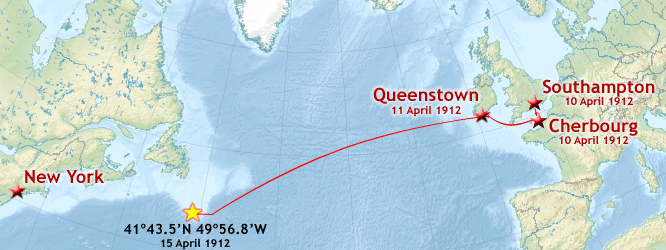
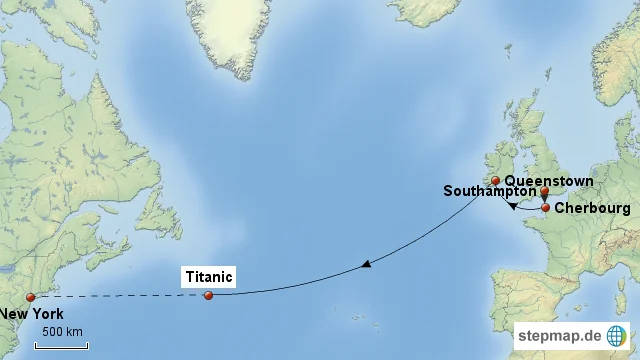

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot  as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Exploration

## Load Data

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')


Data consists of 891 entries and 12 columns. Our target column is Survived column. 

## Basic Exploration

In [3]:
print(train_data.shape)
print(train_data.dtypes)

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Dataset contains some missing values. In Cabin column there are almost 80% of NaN values, this suggests that we should get rid of this column later. NaN values occures also in Age and Embarked columns, but they are not so numerous.

In [4]:
print(train_data.isna().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualization

1. We can see that most women survived the disaster, while most men died.
2. By looking at the Pclass plot, we can see that the 3rd class (lower deck) have the best survival-to-death ratio, which is somewhat unexpected.
3. As shown in the third graph, over 50% of Titanic passengers and crew members died.
4. In the last graph, we see that most people boarded the Titanic at the first port, Southampton. Most of the deaths also occurred among those who embarked there, which could be related to the possibly higher number of crew members.


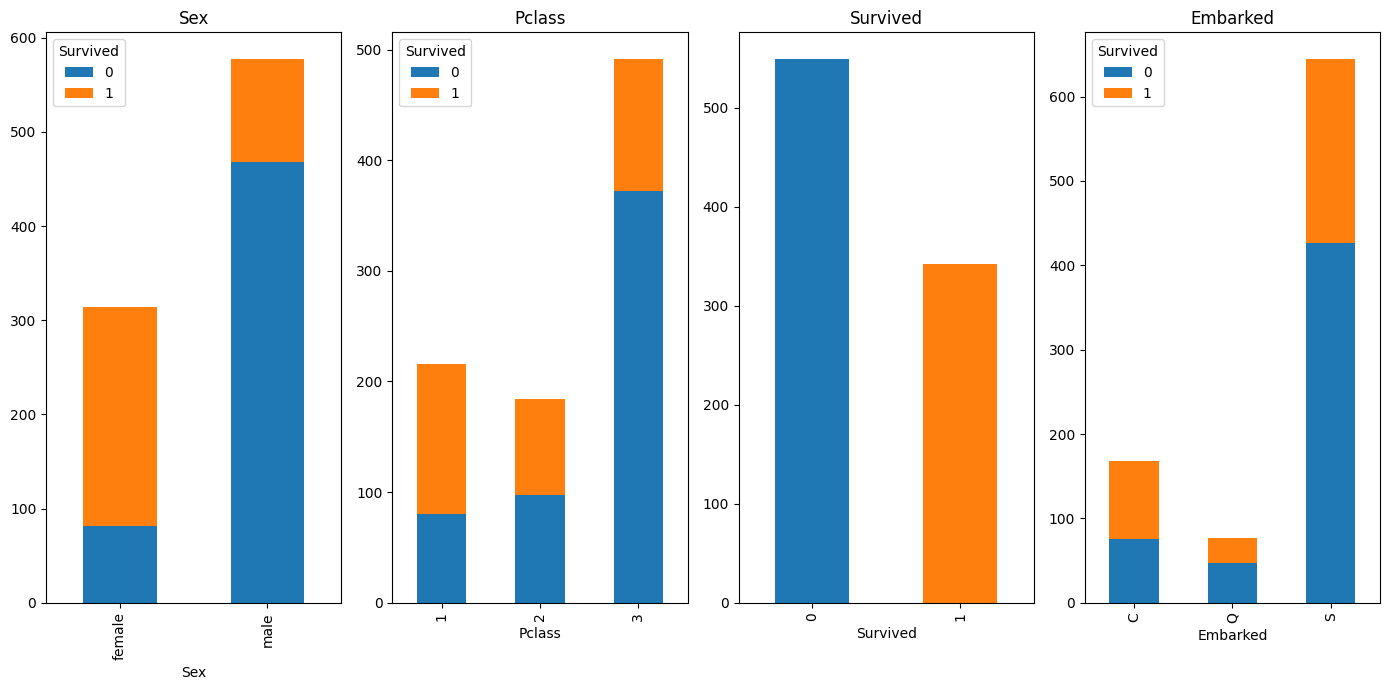

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(14, 7))

count_data = pd.crosstab(train_data['Sex'], train_data['Survived'])
count_data.plot(kind='bar', stacked=True, ax=axs[0], color=['#1f77b4', '#ff7f0e'])
axs[0].set_title('Sex')

count_data = pd.crosstab(train_data['Pclass'], train_data['Survived'])
count_data.plot(kind='bar', stacked=True, ax=axs[1], color=['#1f77b4', '#ff7f0e'])
axs[1].set_title('Pclass')

train_data['Survived'].value_counts().plot(kind='bar', ax=axs[2], color=['#1f77b4', '#ff7f0e'])
axs[2].set_title('Survived')

count_data = pd.crosstab(train_data['Embarked'], train_data['Survived'])
count_data.plot(kind='bar', stacked=True, ax=axs[3], color=['#1f77b4', '#ff7f0e'])
axs[3].set_title('Embarked')

plt.tight_layout()

Looking at the histogram of the Age column, we can see a right skew. Despite the high number of observations for those under the age of 5, the histogram can still be classified as unimodal. The most common (dominant) age of passengers is around 25.

<Axes: >

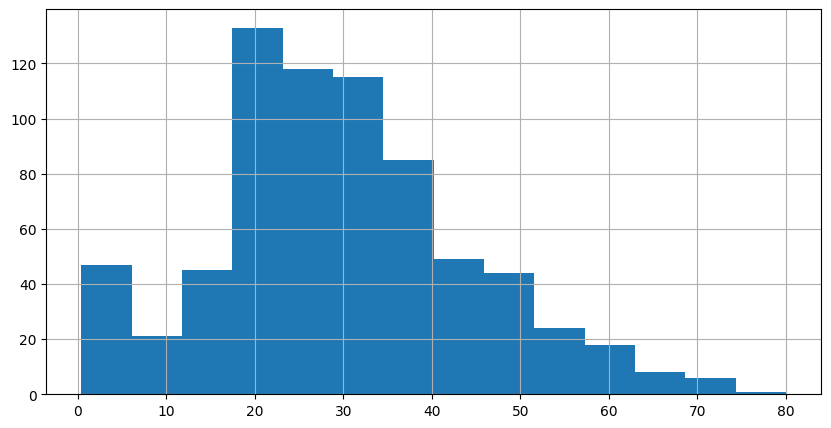

In [7]:
train_data.Age.hist(bins=14, figsize=(10, 5))

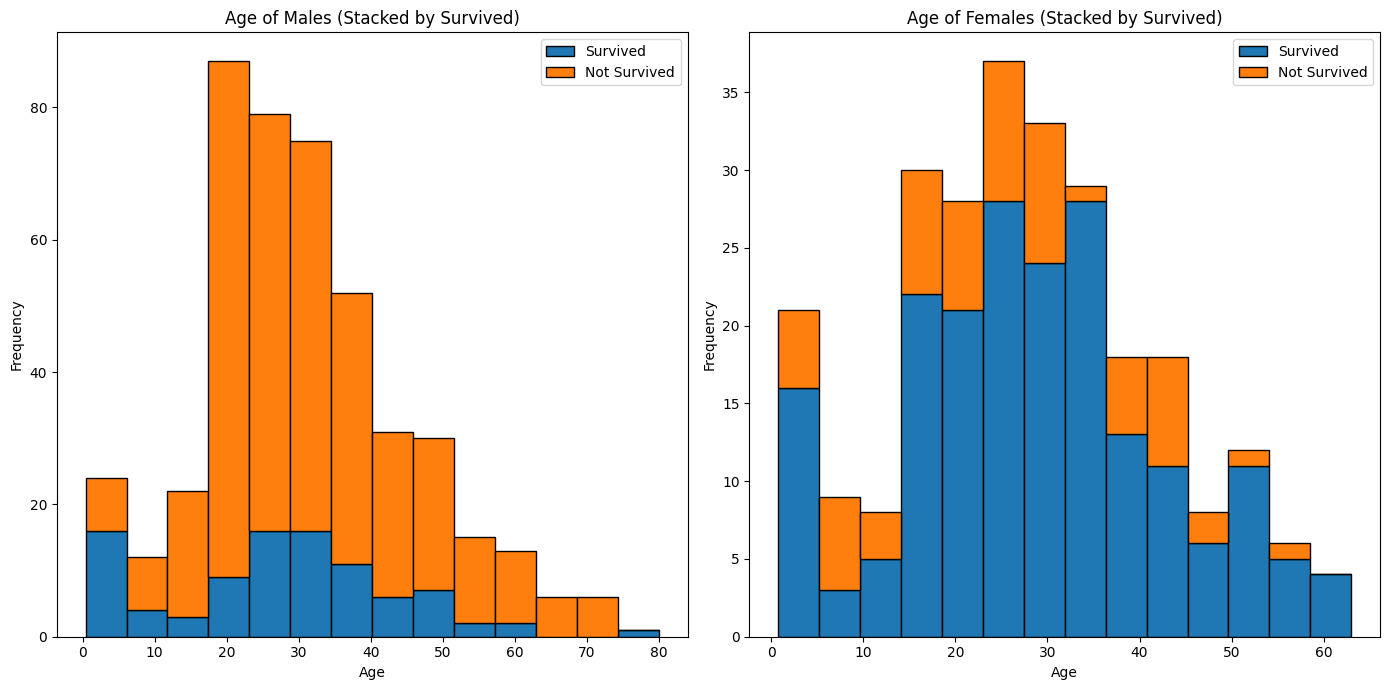

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

male_data = train_data[train_data.Sex == 'male']
male_survived = male_data[male_data['Survived'] == 1]['Age']
male_not_survived = male_data[male_data['Survived'] == 0]['Age']

axs[0].hist([male_survived, male_not_survived], bins=14, stacked=True,
            label=['Survived', 'Not Survived'], color=['#1f77b4', '#ff7f0e'], edgecolor='black')

axs[0].set_title('Age of Males (Stacked by Survived)')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')
axs[0].legend()

female_data = train_data[train_data.Sex == 'female']
female_survived = female_data[female_data['Survived'] == 1]['Age']
female_not_survived = female_data[female_data['Survived'] == 0]['Age']

axs[1].hist([female_survived, female_not_survived], bins=14, stacked=True, 
            label=['Survived', 'Not Survived'], color=['#1f77b4', '#ff7f0e'], edgecolor='black')

axs[1].set_title('Age of Females (Stacked by Survived)')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()


# Data Transformation

In [9]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Drop Columns
Drop columns that we don't want to use for model building

In [10]:
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket'])

## Drop NaN
Since the majority of entries in the Cabin column are missing, we will drop this column. The Embark column has only two missing values, so we will drop those rows.

In [11]:
train_data = train_data.dropna(subset=['Embarked'])

train_data = train_data.drop(columns=['Cabin'])

## Convert to Numerical

In [12]:
train_data.loc[:, 'Sex'] = train_data['Sex'].replace({'male': '0', 'female': '1'})
train_data.loc[:, 'Sex'] = train_data['Sex'].astype(int)

one_hot = pd.get_dummies(train_data['Embarked'])
train_data = train_data.drop(columns=['Embarked'])
train_data = train_data.join(one_hot)

## Missing Values
To address the NaN values in the dataset, we need to handle them appropriately.  As for the Age column, we will fill the missing values using the KNNImputer.

In [13]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
impute_data = imputer.fit_transform(train_data)
train_data = pd.DataFrame(impute_data , columns=train_data.columns)

In [14]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0.0,3.0,0.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0
1,1.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0
2,1.0,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0
3,1.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0
4,0.0,3.0,0.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0


<Figure size 1400x1400 with 0 Axes>

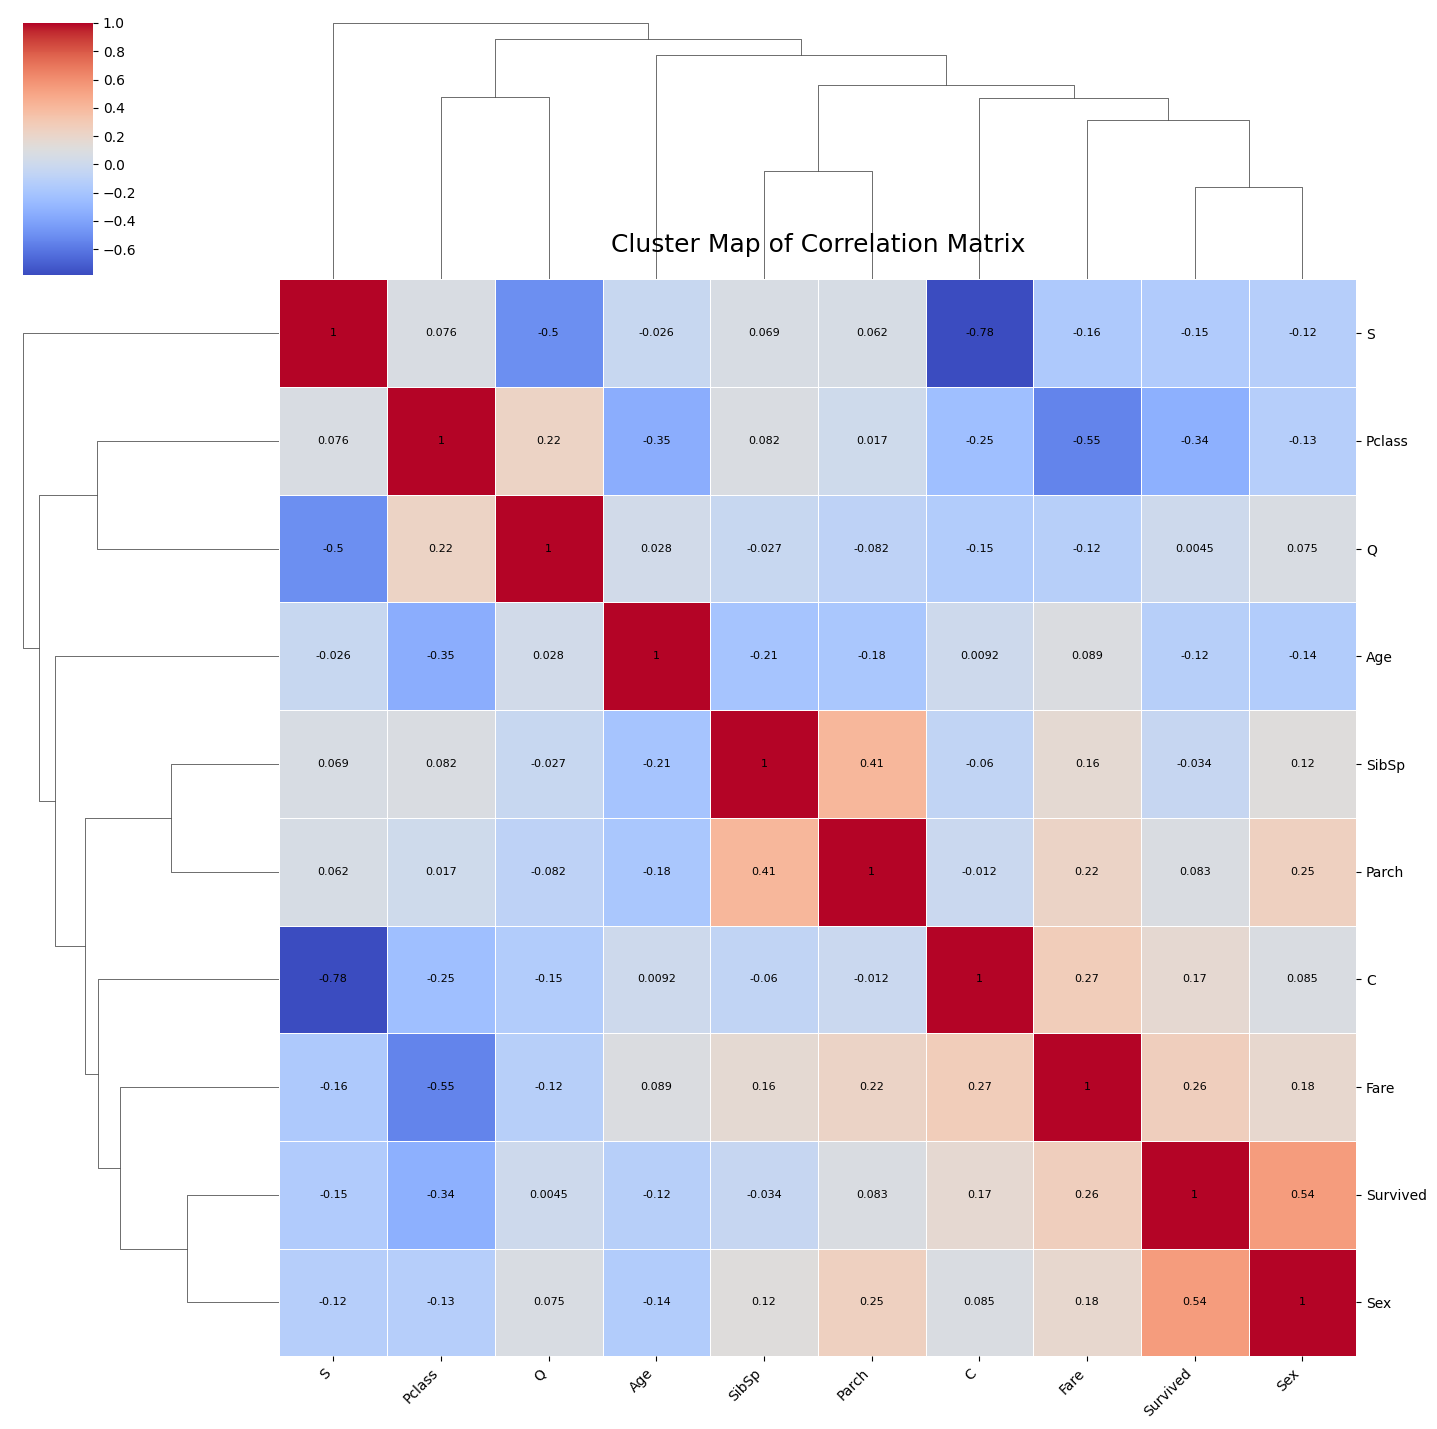

In [15]:
plt.figure(figsize=(14, 14))
g = sns.clustermap(train_data.corr(), method='average', cmap='coolwarm', annot=True,
    annot_kws={'size': 8, 'color': 'black'}, linewidths=0.5, figsize=(14, 14))

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

g.ax_heatmap.set_title('Cluster Map of Correlation Matrix', fontsize=18, pad=20)

plt.show()


We can see a strong correlation between survival and sex. There is also a weaker correlation with other columns, such as Pclass, Fare, and the embarkation ports C and S.

Text(0.5, 1.0, 'Survived')

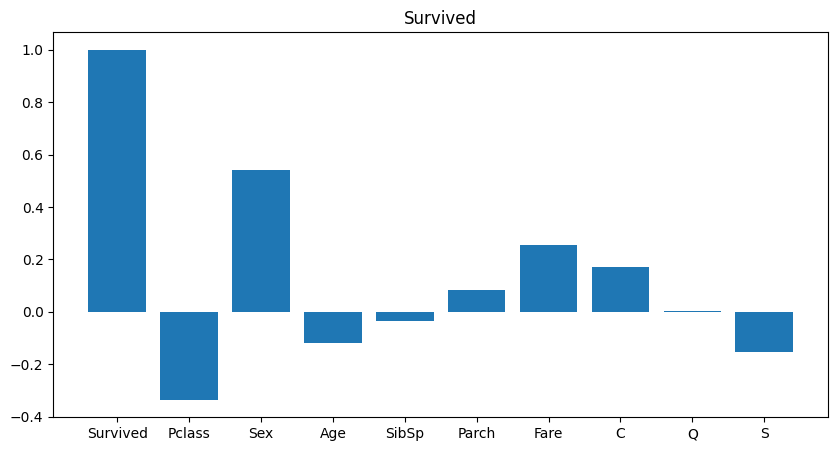

In [16]:
correlations = train_data.corr()

plt.figure(figsize=(10,5))
plt.tight_layout()
plt.bar(correlations["Survived"].index , correlations["Survived"].values)
plt.title("Survived")

# Model Building

In [17]:
y = train_data.Survived
X = train_data.iloc[:, train_data.columns != 'Survived']


## Decision tree

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

clf = clf.fit(X, y)


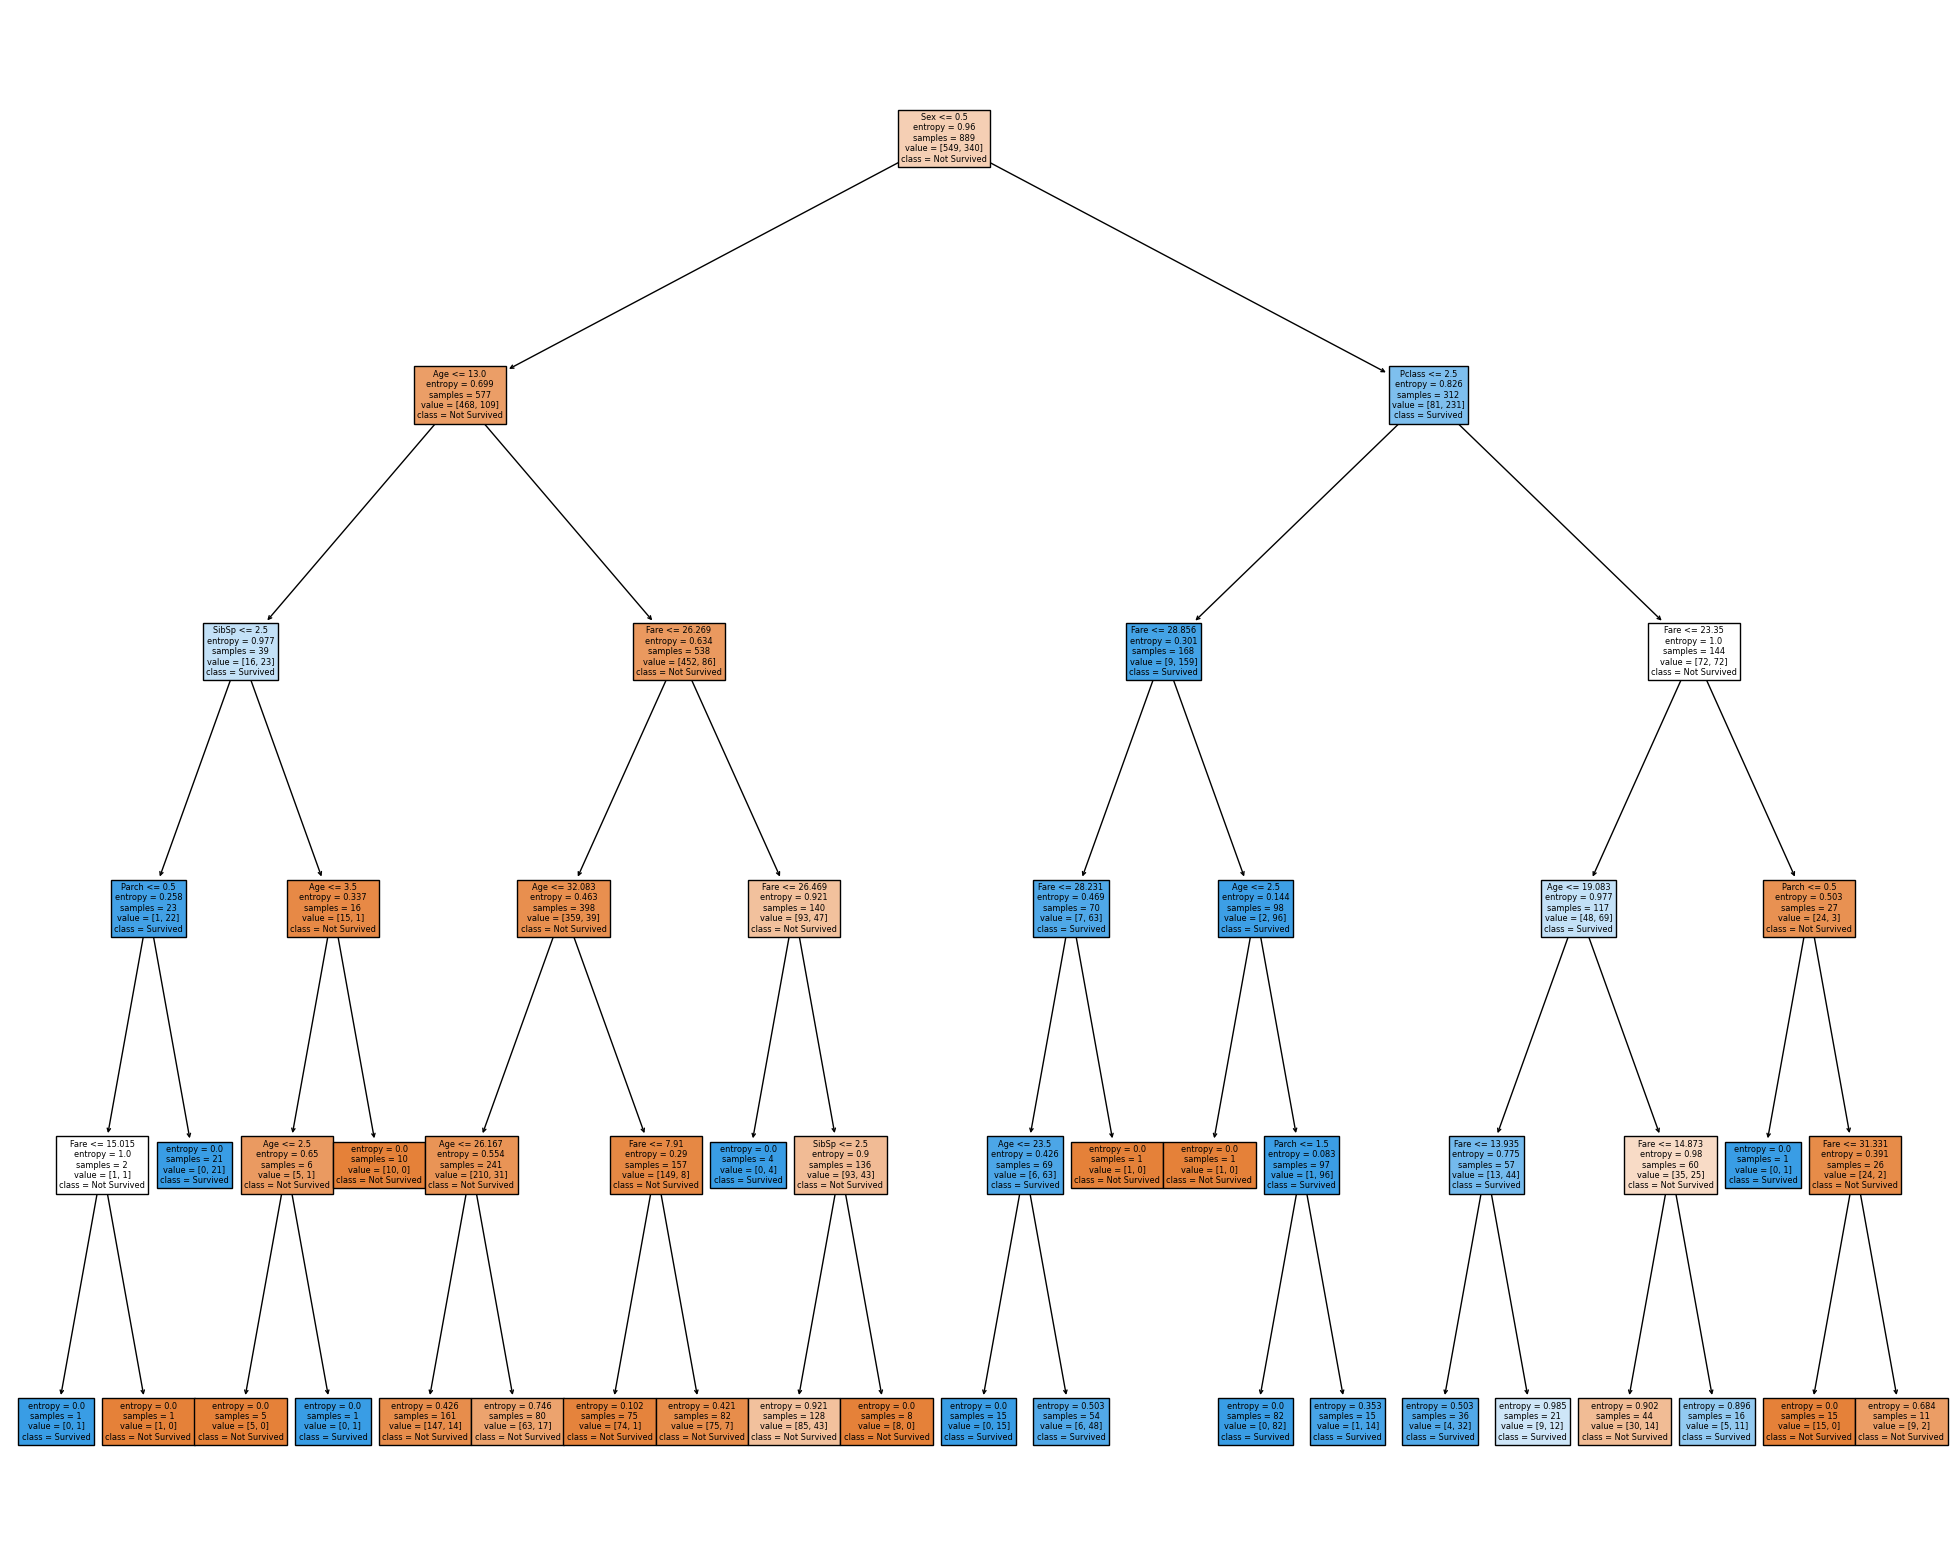

In [19]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
        feature_names=X.columns, 
        class_names=['Not Survived', 'Survived'], 
        filled=True
)


# Predict on Test Data

## Prepare Data

In [20]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')


In [21]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [22]:
# Drop columns
test_data = test_data.drop(columns=['PassengerId', 'Ticket', 'Name', 'Cabin'])

# Convert numerical
test_data.loc[:, 'Sex'] = test_data['Sex'].replace({'male': '0', 'female': '1'})
test_data.loc[:, 'Sex'] = test_data['Sex'].astype(int)

one_hot = pd.get_dummies(test_data['Embarked'])
test_data = test_data.drop(columns=['Embarked'])
test_data = test_data.join(one_hot)

# Fill missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
impute_data = imputer.fit_transform(test_data)
test_data = pd.DataFrame(impute_data , columns=test_data.columns)

X_test = test_data


In [23]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3.0,0.0,34.5,0.0,0.0,7.8292,0.0,1.0,0.0
1,3.0,1.0,47.0,1.0,0.0,7.0000,0.0,0.0,1.0
2,2.0,0.0,62.0,0.0,0.0,9.6875,0.0,1.0,0.0
3,3.0,0.0,27.0,0.0,0.0,8.6625,0.0,0.0,1.0
4,3.0,1.0,22.0,1.0,1.0,12.2875,0.0,0.0,1.0


## Predict

In [24]:
y_pred = clf.predict(X_test)

y_pred = y_pred.astype(int).tolist()

In [25]:
submission_base = pd.read_csv('/kaggle/input/titanic/test.csv')

PassengerIds = submission_base.loc[:, 'PassengerId']

submission = pd.DataFrame({'PassengerId': PassengerIds, 'Survived': y_pred})

submission.to_csv('submission.csv', index=False)